# Symmetric power spectra in 2D images

## Last edited by Charles Romero 08 June 2025

That is, we can characterize the power spectra with $k_r$, where $k_r = (k_x^2 + k_y^2)^{1/2}$

In [1]:
import MockMaps as MM
import matplotlib.pyplot as plt
import numpy as np
import CalculatePS as CPS

In [2]:
from importlib import reload
MM=reload(MM)

Let's define some simple parameters for an image and a power spectrum.

In [3]:
nx = 1024        # Number of pixels in x-direction
ny = 1024        # Number of pixels in y-direction
pixsize = 1.0    # Assume this is in kpc
kc = 3e-3        # Assume this is in [pixsize]^(-1) -- so kpc^-1 in our case.
slope = -3       # Power goes as k**slope
p0 = 1e2         # Arbitrary units at the moment

In [4]:
ks    = np.logspace(-4,0.5,500)
ps    = MM.get_P3d(ks,slope=slope,kc=kc,p0=p0) # More optional inputs: kdis=kdis,eta_c=eta_c,eta_d=eta_d
ymin  = MM.get_P3d(np.array([kc/2.0]),slope=slope,kc=kc,p0=p0)

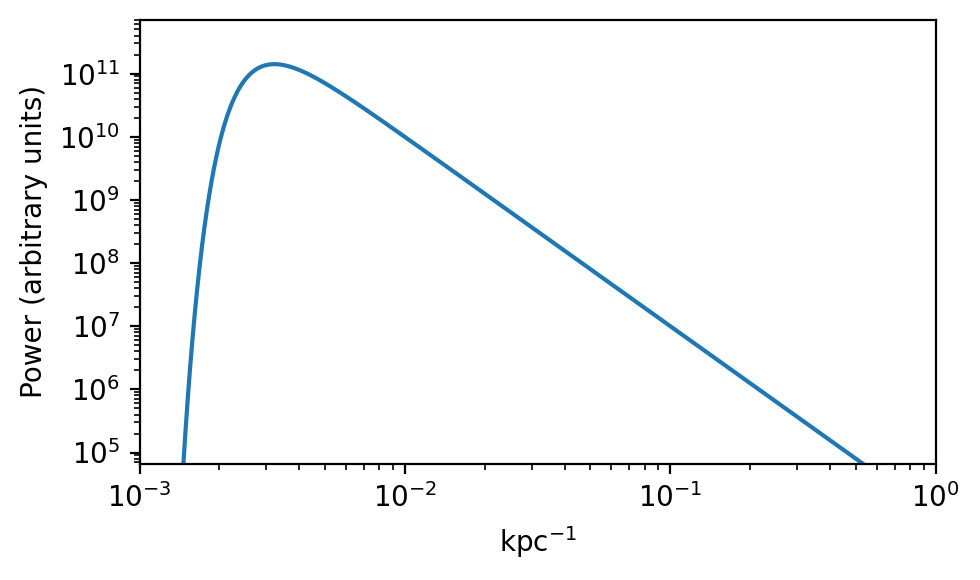

In [5]:
psfig = plt.figure(1,figsize=(5,3),dpi=200)
psfig.clf() # If rerunning cell
psax = psfig.add_subplot(111)
psax.plot(ks,ps)
psax.set_yscale("log")
psax.set_xscale("log")
psax.set_xlabel(r"kpc$^{-1}$")
psax.set_ylabel("Power (arbitrary units)")
psax.set_xlim([kc/3.0,1.0/pixsize])
psax.set_ylim([ymin/5.0,np.max(ps)*5.0])
psfig.tight_layout()
#psfig.savefig() # Save figure?

In [6]:
image = MM.make_image(ks,ps,nx=nx,ny=ny,cx=nx//2,cy=ny//2,pixsize=pixsize)

/home/charles/Python/ForGitHub/EZ2use_SBF/MockMaps.py:673: RuntimeWarning: divide by zero encountered in log
  psout       = np.exp(np.interp(np.log(gk),np.log(kbin),np.log(psbin)))


In [7]:
np.max(image)

17495.010533382934

In [8]:
center = [nx//2,ny//2]
annular_width = 64
nRings = int(np.round(nx*1.4*pixsize/(2*annular_width)))
print("Using ",nRings)
rings = (np.arange(nRings+1) ) * annular_width 
kmax = 1.0 / (4*pixsize) # Good to have a buffer. We cannot accurately recover within 1/(3*pixsize)
kmin = 2.0 / nx
print("Fitting between ",kmax," and ",kmin," (inverse units of scale assigned to pixsize).")
nkbins_f = (np.log(kmax)-np.log(kmin) ) / np.log(2) # This is how many ~independent points you could make
nkbins = int(np.round(nkbins_f*4.0)) # Let's oversample by a factor of 4 just to get some nice looking plots
print("Using ",nkbins," bins")

Using  11
Fitting between  0.25  and  0.001953125  (inverse units of scale assigned to pixsize).
Using  28  bins


In [9]:
additional_mask = np.ones(image.shape) # An optional input (if no input given, it makes this same mask, i.e. ones)
kbin, MH_pk, MH_S2k, MH_Ak, MH_err = CPS.MaskRings(image, center, rings, pixsize,kmax=kmax,kmin=kmin,nkbins=nkbins,
                                                   addmask=additional_mask)

In [10]:
colors = plt.cm.jet(np.linspace(0,1,nRings))

def addcirc(radius):

    thetas = np.arange(int(np.ceil(radius*np.pi)))*2/radius
    xx = np.cos(thetas)*radius
    yy = np.sin(thetas)*radius

    return xx,yy


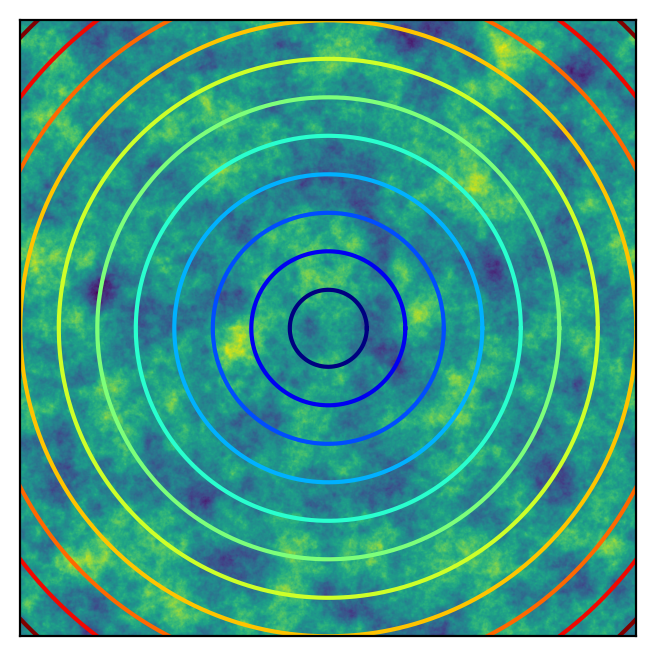

In [11]:
imFig = plt.figure(2,figsize=(4,4),dpi=200)
imAx = imFig.add_subplot(111)
imAx.imshow(image)
xlims = imAx.get_xlim()
ylims = imAx.get_ylim()
imAx.set_xlim(xlims)
imAx.set_ylim(ylims)
for ri in range(nRings):
    cx,cy = addcirc(rings[ri+1]/pixsize)
    imAx.plot(cx+center[0],cy+center[1],color=colors[ri])
    
imAx.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

In [12]:
print(kbin.shape)
print(MH_pk.shape)

(28,)
(28, 11)


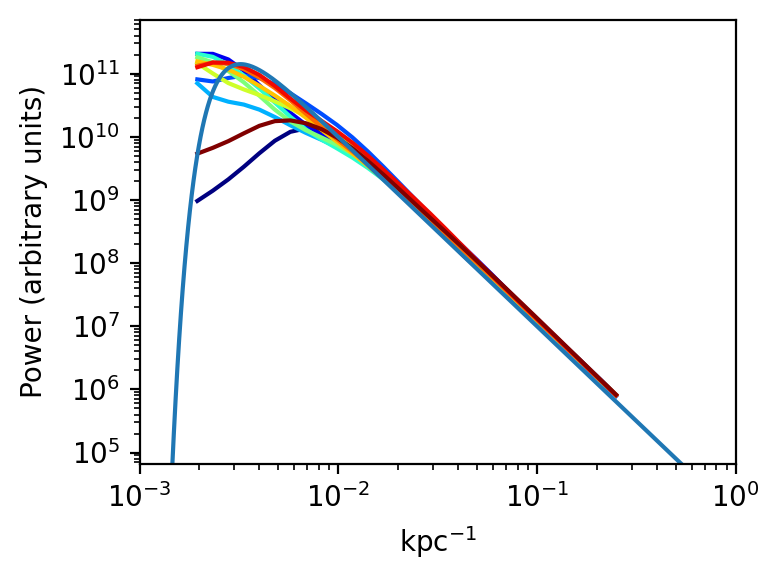

In [13]:
a12Fig = plt.figure(3,figsize=(4,3),dpi=200)
a12Ax = a12Fig.add_subplot(111)
for ri in range(nRings):
    a12Ax.plot(kbin,MH_pk[:,ri],color=colors[ri])

a12Ax.plot(ks,ps)
a12Ax.set_yscale("log")
a12Ax.set_xscale("log")
a12Ax.set_xlabel(r"kpc$^{-1}$")
a12Ax.set_ylabel("Power (arbitrary units)")
a12Ax.set_xlim([kc/3.0,1.0/pixsize])
a12Ax.set_ylim([ymin/5.0,np.max(ps)*5.0])
a12Fig.tight_layout()

That's OK, but we're traversing quite a bit of power. Let's plot these as amplitude spectra

In 2D, $A_k = \sqrt{2 \pi k^2 P_k}$

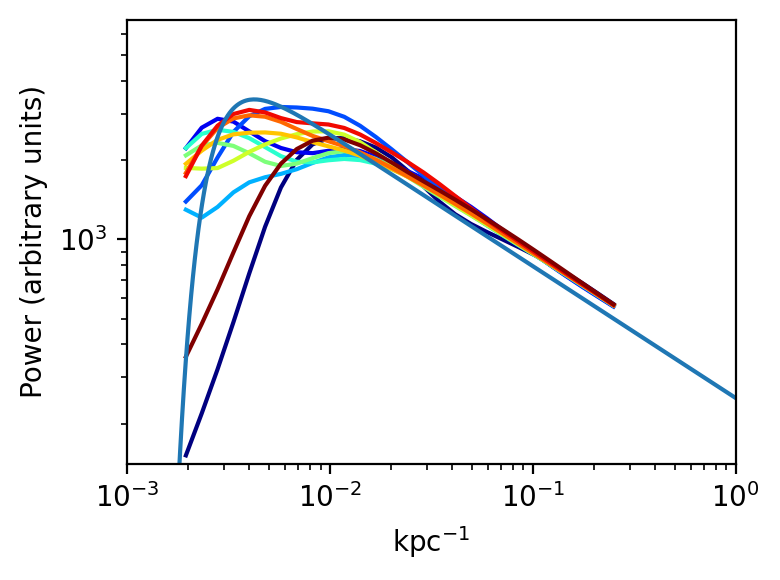

In [14]:
ampFig = plt.figure(4,figsize=(4,3),dpi=200)
ampAx = ampFig.add_subplot(111)
for ri in range(nRings):
    amp_spec = np.sqrt(2*np.pi*kbin**2 * MH_pk[:,ri])
    ampAx.plot(kbin,amp_spec,color=colors[ri])

inp_spec = np.sqrt(2*np.pi*ks**2 * ps)
ampAx.plot(ks,inp_spec)
ampAx.set_yscale("log")
ampAx.set_xscale("log")
ampAx.set_xlabel(r"kpc$^{-1}$")
ampAx.set_ylabel("Power (arbitrary units)")
ampAx.set_xlim([kc/3.0,1.0/(1*pixsize)])
ampAx.set_ylim([50*kmin*np.sqrt(np.pi * 2 * ymin),np.max(inp_spec)*2.0])
ampFig.tight_layout()

It looks like the curves inferred power spectra are quite noisy.

In [15]:
kFFT,pFFT = MM.calculated_P2D(image,pixsize,corrN=True) # Calculate PS via FFT (and bin in a reasonable manner)

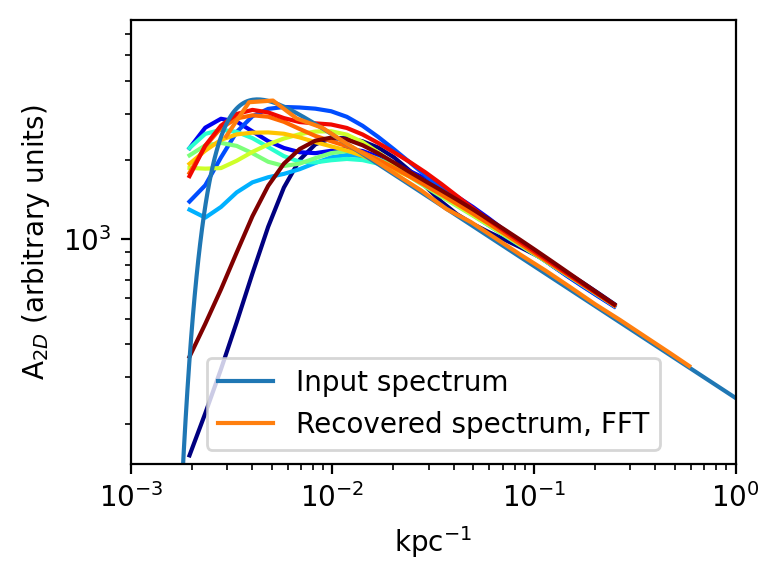

In [16]:
ampFig = plt.figure(4,figsize=(4,3),dpi=200)
ampFig.clf()
ampAx = ampFig.add_subplot(111)
for ri in range(nRings):
    amp_spec = np.sqrt(2*np.pi*kbin**2 * MH_pk[:,ri])
    ampAx.plot(kbin,amp_spec,color=colors[ri])

inp_spec = np.sqrt(2*np.pi*ks**2 * ps)
out_spec = np.sqrt(2*np.pi*kFFT**2 * pFFT)
ampAx.plot(ks,inp_spec,label="Input spectrum")
ampAx.plot(kFFT,out_spec,label="Recovered spectrum, FFT")
ampAx.set_yscale("log")
ampAx.set_xscale("log")
ampAx.set_xlabel(r"kpc$^{-1}$")
ampAx.set_ylabel(r"A$_{2D}$ (arbitrary units)")
ampAx.set_xlim([kc/3.0,1.0/(1*pixsize)])
ampAx.set_ylim([50*kmin*np.sqrt(np.pi * 2 * ymin),np.max(inp_spec)*2.0])
ampAx.legend()
ampFig.tight_layout()

Well even the FFT has some noise. This is due to sample (or cosmic) variance.

Given that we are generating images ("synthetic data") with a known power spectrum, we can simply increase this to generating N images, and take the averages of recovered spectra.

In [17]:
nImgs = 9
PS_viaA12 = np.zeros(MH_pk.shape)
PS_viaFFT = np.zeros(pFFT.shape)
for i in range(nImgs):
    print(i) # Could import tqdm and have a progress bar
    image = MM.make_image(ks,ps,nx=nx,ny=ny,cx=nx//2,cy=ny//2,pixsize=pixsize)
    kbin, MH_pk, MH_S2k, MH_Ak, MH_err = CPS.MaskRings(image, center, rings, pixsize,kmax=kmax,kmin=kmin,nkbins=nkbins)
    kFFT,pFFT = MM.calculated_P2D(image,pixsize,corrN=True) # Calculate PS via FFT (and bin in a reasonable manner)
    PS_viaA12 += MH_pk
    PS_viaFFT += pFFT
PS_viaA12 /= nImgs
PS_viaFFT /= nImgs

0
1
2
3
4
5
6
7
8


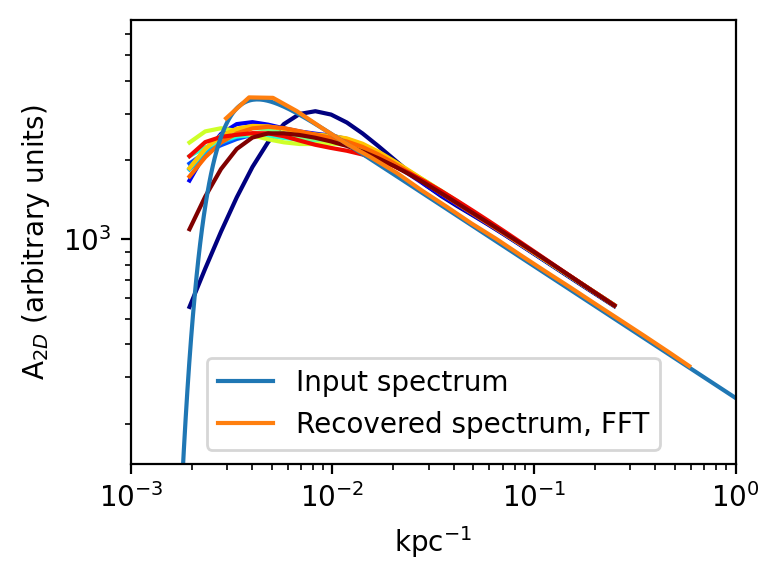

In [18]:
lowSVFig = plt.figure(4,figsize=(4,3),dpi=200)
lowSVFig.clf()
lowSVAx = lowSVFig.add_subplot(111)
for ri in range(nRings):
    lowSV_spec = np.sqrt(2*np.pi*kbin**2 * PS_viaA12[:,ri])
    lowSVAx.plot(kbin,lowSV_spec,color=colors[ri])

inp_spec = np.sqrt(2*np.pi*ks**2 * ps)
out_spec = np.sqrt(2*np.pi*kFFT**2 * PS_viaFFT)
lowSVAx.plot(ks,inp_spec,label="Input spectrum")
lowSVAx.plot(kFFT,out_spec,label="Recovered spectrum, FFT")
lowSVAx.set_yscale("log")
lowSVAx.set_xscale("log")
lowSVAx.set_xlabel(r"kpc$^{-1}$")
lowSVAx.set_ylabel(r"A$_{2D}$ (arbitrary units)")
lowSVAx.set_xlim([kc/3.0,1.0/(1*pixsize)])
lowSVAx.set_ylim([50*kmin*np.sqrt(np.pi * 2 * ymin),np.max(inp_spec)*2.0])
lowSVAx.legend()
lowSVFig.tight_layout()

There's still a little scatter, but we can start to infer what biases are induced from the Arevalo 2012 method.

An exercise for the reader/user is to identify the sources of the biases.